# ***화승***

## ***IMPORT LIBRARY***
---

In [1]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from math import ceil
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from collections import Counter
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

In [2]:
### Parameters 
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm' 
p_type = 'CMB'

## ***Load Dataset***
---

In [3]:
### Load Raw Data 
# Data Import 
log_df, qa_df, recipe_df, info, weather_df = import_raw_data(path) 
recipe_origin_df = recipe_df.copy() 

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (9478081, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [4]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (8566802, 39)
Log Train Dataset: (128985, 18)


In [5]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (242922, 4)
Qa Train Dataset: (137180, 14)


In [6]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_origin_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [7]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (128985, 35)


In [8]:
### Get Cluster Column 
dataset = create_cluster_col(df3, p_type)  

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (19156, 36)


In [9]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    "cycle time", "Ct 90_결과", "M/B_결과", "M/B_기준",
    "Scorch_결과", "Vm_결과", "경도_결과"
]

# Print 
print('='*100)
print(dataset[target_lst].count())
print('='*100)

cycle time    19040
Ct 90_결과         12
M/B_결과         7238
M/B_기준         6479
Scorch_결과         0
Vm_결과             0
경도_결과             0
dtype: int64


## ***MODELLING***
---

In [10]:
### Train Test Split 
# Targets 
targets = ['cycle time','M/B_결과']

# Cycle Time 
cycle_train_dataset, cycle_test_dataset, cycle_scaler, cycle_scaler_cols = create_train_test_dataset(dataset, targets[0], p_type)

# M/B 
mb_train_dataset, mb_test_dataset, mb_scaler, mb_scaler_cols = create_train_test_dataset(dataset, targets[1], p_type)

# Print 
print('='*100)
print(f"{'cycle time':<21} | {len(cycle_train_dataset):>14,} | {len(cycle_test_dataset):>13,}")
print(f"{'M/B_결과':<20} | {len(mb_train_dataset):>14,} | {len(mb_test_dataset):>13,}")
print("="*100) 

cycle time            |          4,376 |         1,027
M/B_결과               |          4,376 |         1,027


[I 2025-10-27 19:02:11,196] A new study created in memory with name: no-name-af346adc-63c7-4690-ab51-8eabee933b48


학습할 Tree Features: 21 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'MB_feature', 'Cluster']
학습 Tree 데이터 수: 4376


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-27 19:02:12,234] Trial 0 finished with value: 9.599666388611636 and parameters: {'n_estimators': 358, 'max_depth': 12, 'learning_rate': 0.28866042337752257, 'subsample': 0.7713220514879902, 'gamma': 0.4222739344524035, 'reg_lambda': 0.0017500290477828401}. Best is trial 0 with value: 9.599666388611636.
[I 2025-10-27 19:02:16,894] Trial 1 finished with value: 11.348141816719973 and parameters: {'n_estimators': 817, 'max_depth': 6, 'learning_rate': 0.0021472277081621798, 'subsample': 0.9161431707692165, 'gamma': 0.05458033085742736, 'reg_lambda': 1.2334178453005187}. Best is trial 0 with value: 9.599666388611636.
[I 2025-10-27 19:02:20,536] Trial 2 finished with value: 12.615148153954218 and parameters: {'n_estimators': 647, 'max_depth': 6, 'learning_rate': 0.002713362379427765, 'subsample': 0.9784777144308516, 'gamma': 0.44307593444523496, 'reg_lambda': 0.11824759795048932}. Best is trial 0 with value: 9.599666388611636.
[I 2025-10-27 19:02:25,632] Trial 3 finished with value

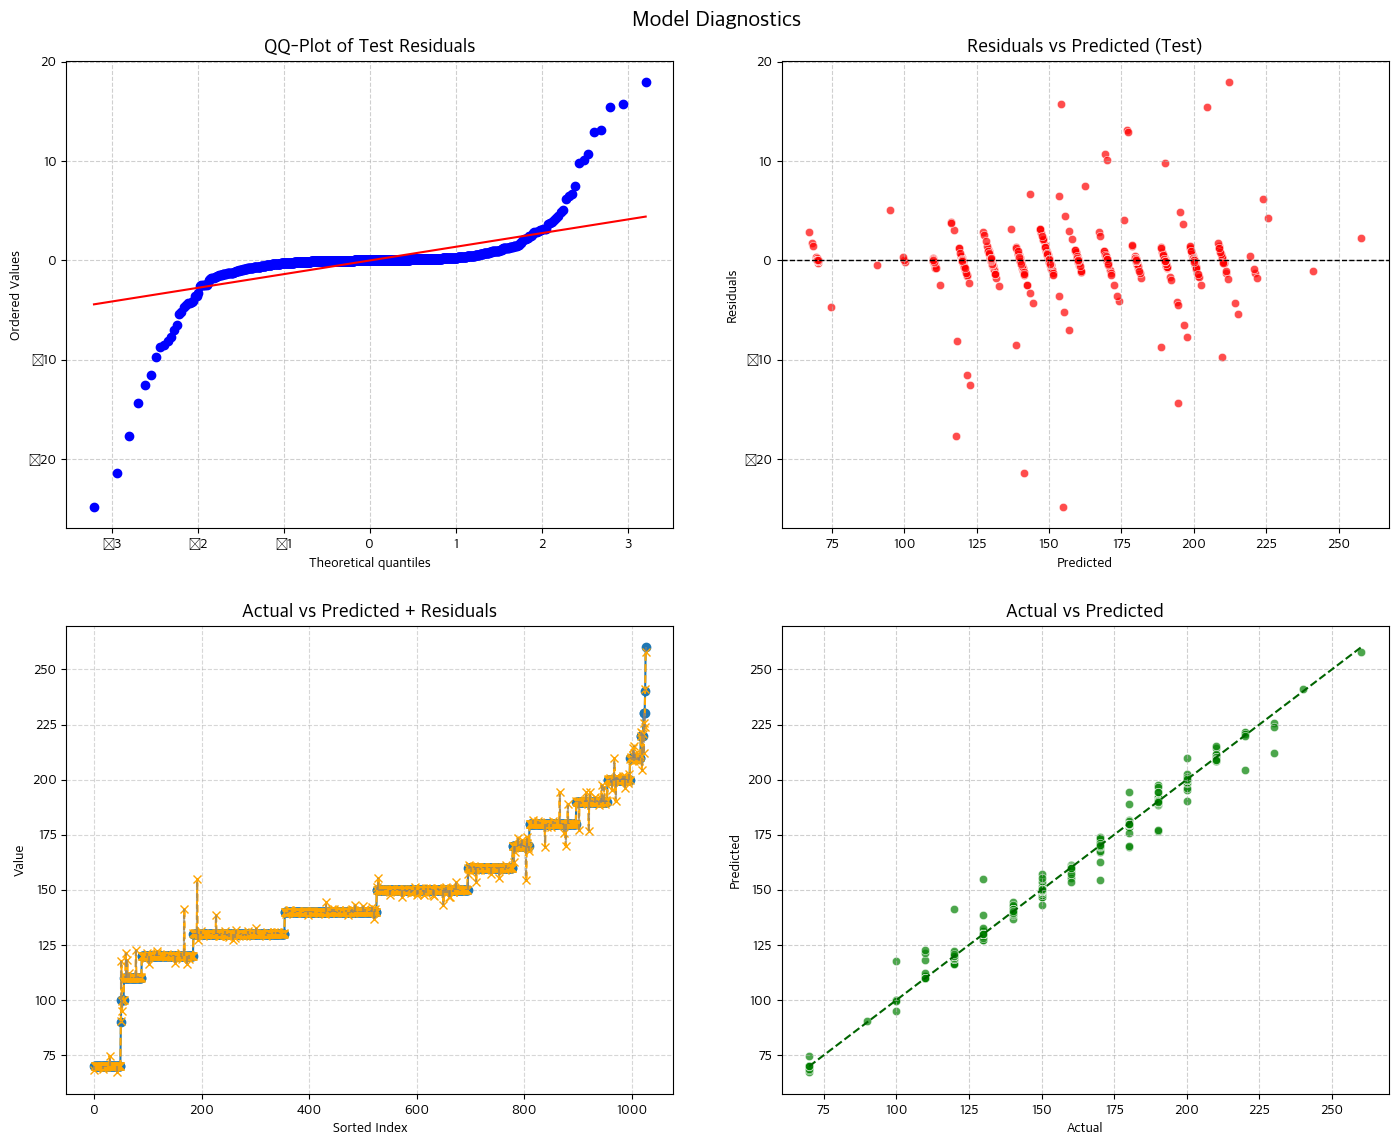

[I 2025-10-27 19:03:02,540] A new study created in memory with name: no-name-e0ef846e-73db-42ed-84ac-5c131881da37


Train Accuracy
Train RMSE : 0.205
Train R2   : 1.000
Train SMAPE : 0.10
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 2.144
Test R2   : 0.995
Test SMAPE : 0.45
학습할 Tree Features: 21 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'MB_feature', 'Cluster']
학습 Tree 데이터 수: 4376


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-27 19:03:09,669] Trial 0 finished with value: 1.519960486172482 and parameters: {'n_estimators': 1165, 'max_depth': 12, 'learning_rate': 0.015987539152940627, 'subsample': 0.8486449590429241, 'gamma': 0.13388124340854268, 'reg_lambda': 0.017563927639058466}. Best is trial 0 with value: 1.519960486172482.
[I 2025-10-27 19:03:37,469] Trial 1 finished with value: 1.513147561842765 and parameters: {'n_estimators': 2565, 'max_depth': 9, 'learning_rate': 0.002139165702553964, 'subsample': 0.8410353009981391, 'gamma': 0.16652179380498333, 'reg_lambda': 0.010580664237612638}. Best is trial 1 with value: 1.513147561842765.
[I 2025-10-27 19:03:40,572] Trial 2 finished with value: 4.803376187309016 and parameters: {'n_estimators': 433, 'max_depth': 7, 'learning_rate': 0.0024749423420373498, 'subsample': 0.7924634965379099, 'gamma': 0.118874501840946, 'reg_lambda': 1.8001890040728945}. Best is trial 1 with value: 1.513147561842765.
[I 2025-10-27 19:03:46,777] Trial 3 finished with value

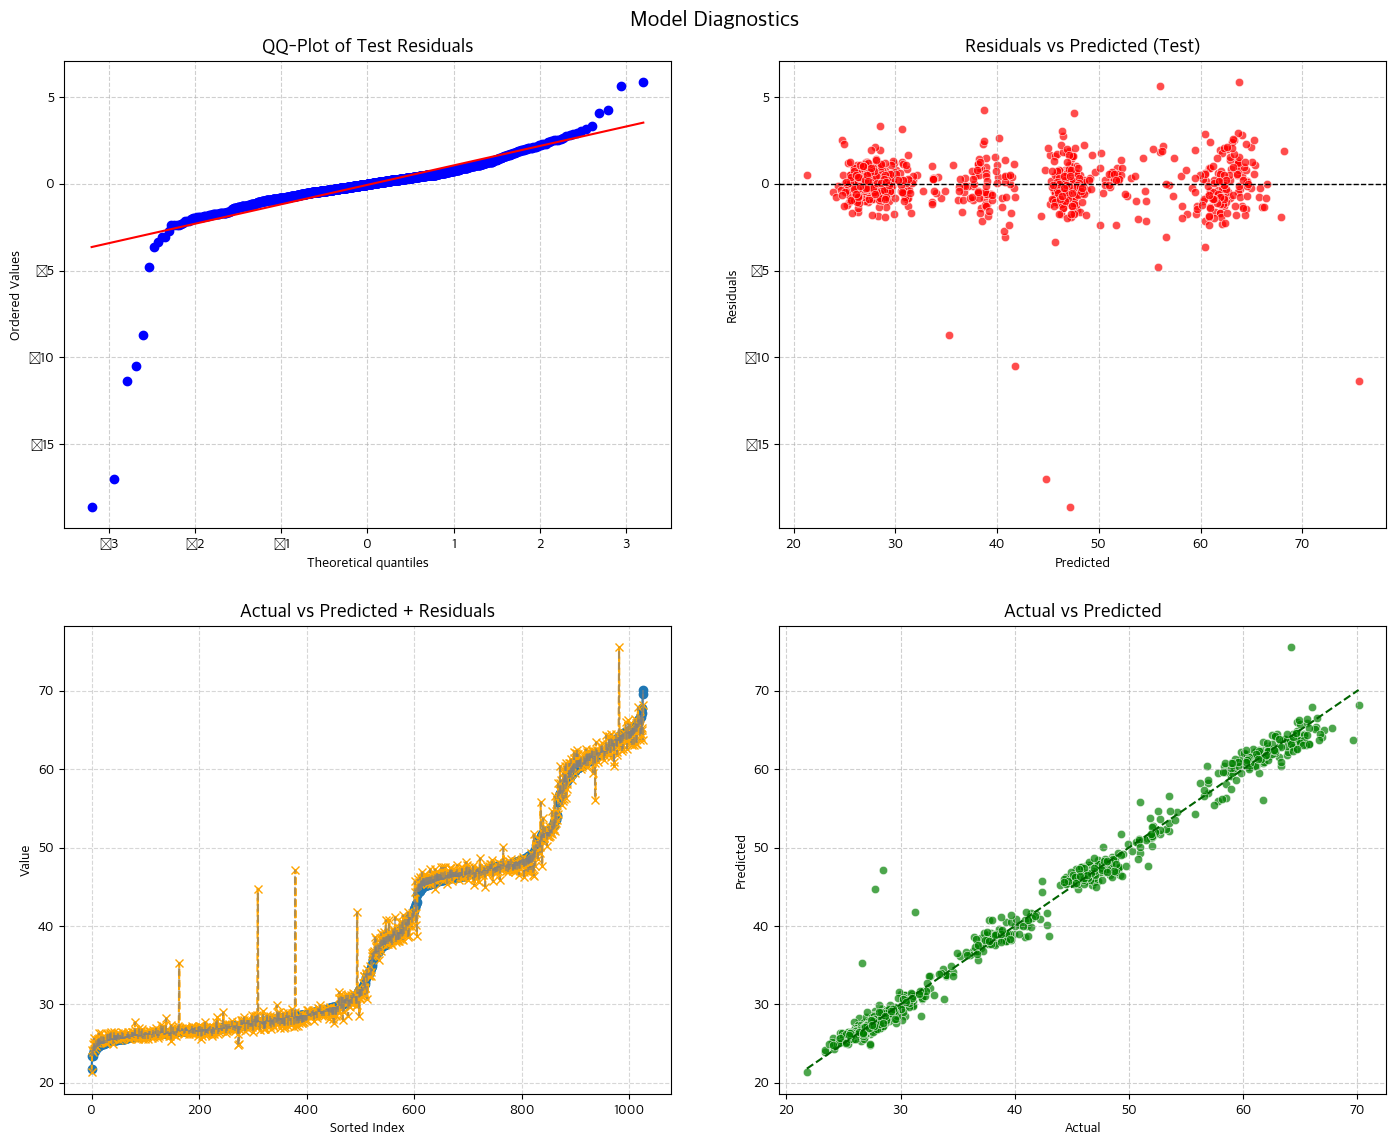

Train Accuracy
Train RMSE : 0.214
Train R2   : 1.000
Train SMAPE : 0.48
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.367
Test R2   : 0.989
Test SMAPE : 1.95


In [14]:
### Modelling 
# Cycle Time 
cycle_model, cycle_importance = train_tree(cycle_train_dataset, cycle_test_dataset, target_col='cycle time')

# M/B 
mb_model, mb_importance = train_tree(mb_train_dataset, mb_test_dataset, target_col='M/B_결과')
